# invert synthetic data using different parameterizations

## Intro : imports, prompt help

In [1]:
import sys, glob, os
from srfpython import *
try:
    check_herrmann_codes()
except Exception:
    recompile_src90(yes=False)
    check_herrmann_codes()

In [2]:
rm -rf _HerrMet* *.surf96 *.mod96

In [3]:
ls ./*

./tutorial1.ipynb


In [4]:
%run -i ../../srfpython/bin/HerrMet -h

HerrMet V6.0
# ------- main options (s=string, i=int, f=float)
-version, -v          version number, quit
-help, -h   [s...]    help, provide plugin names for details, quit
-example, -ex s [s..] example usage, provide plugin names for details, quit
-w           i        number of virtual workers, default None
-taskset     s        affinity, e.g. "0-3", default None
-lowprio              run processes with low priority if mentioned
-verbose     i        reduce verbosity, 0/1, default 1
# ------- plugins, use --help plugin [plugin ...] for details
--target     set the target data, create temporary directories (rootnames)
--param      create a template parameterization file
--send       send the parameterization to the temporary directories
--run        invert dispersion data using the Markov Chain Monte Carlo method
--extract    compute and write posterior pdf
--display    display target, parameterization, solutions



## I/ Create synthetic data

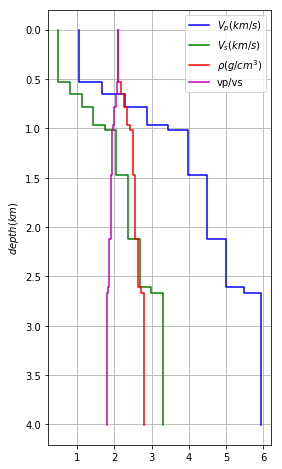

In [5]:
# -----------------
# generate a random depth model
# -----------------
ztop = np.unique(np.sort(np.random.rand(10))) * 3.
ztop[0] = 0.
vs   = np.linspace(.5, 3.3, len(ztop))
pr   = np.linspace(2.1, 1.8, len(ztop))
rh   = np.linspace(2.1, 2.8, len(ztop))
vp = np.array(pr) * np.array(vs)

dm = depthmodel_from_arrays(ztop, vp, vs, rh)
plt.figure(figsize = (4,8))
dm.show(gca())
dm.pr().show(gca(), color = "m", label="vp/vs")
gca().grid(True)
plt.legend()

dm.write96('dmtuto.mod96')

dmtuto.mod96 => dmtuto.surf96
dmtuto.surf96
    Claw wave=L mode=0 type=C flag=T extrapmode=0 N=12
    Claw wave=L mode=1 type=C flag=T extrapmode=1 N=5
    Ulaw wave=L mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=L mode=1 type=U flag=T extrapmode=1 N=5
    Claw wave=R mode=0 type=C flag=T extrapmode=0 N=12
    Claw wave=R mode=1 type=C flag=T extrapmode=1 N=5
    Ulaw wave=R mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=R mode=1 type=U flag=T extrapmode=1 N=5


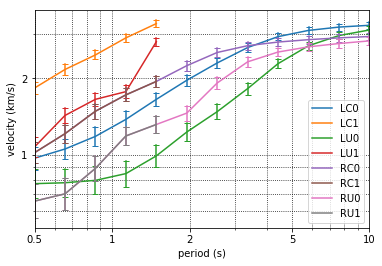

In [6]:
# -----------------
# compute the corresponding dispersion curves
# -----------------

os.system('rm -f dmtuto.surf96')
%run -i ../../srfpython/bin/m96 \
    --disp dmtuto.mod96 \
        -RU0 .1  2. 12 "log" \
        -LU0 .1  2. 12 "log" \
        -RU1 .1  2. 12 "log" \
        -LU1 .1  2. 12 "log" \
        -RC0 .1  2. 12 "log" \
        -LC0 .1  2. 12 "log" \
        -RC1 .1  2. 12 "log" \
        -LC1 .1  2. 12 "log" \
        -save dmtuto.surf96
        
%run -i ../../srfpython/bin/s96 \
    --show dmtuto.surf96 \
        -inline        


## II/ Invert data with 3 different parameterizations (2, 3, or 4 layers)

In [7]:
# -----------------
# clean up, prepare files for 3 inversions
# dmtuto.mod96 = synthetic model (the expected solution)
# dmtuto.surf96 = synthetic data (the data to invert)
# we generate 3 copies of dmtuto.surf96, to be used as targets by HerrMet
# -----------------
os.system('''
rm -rf _HerrMet*
mv dmtuto.surf96  2layers.surf96 #target 1
cp 2layers.surf96 3layers.surf96 #target 2
cp 2layers.surf96 4layers.surf96 #target 3
''')
for _ in glob.glob('./*'):
    print _, 


./dmtuto.mod96 ./2layers.surf96 ./3layers.surf96 ./4layers.surf96 ./tutorial1.ipynb


In [8]:
# -----------------
# set target data, create temporary directories (1 per target file)
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    --target ?layers.surf96 \
        -lunc .3 \
        -ot

writing _HerrMet_2layers/_HerrMet.target
writing _HerrMet_3layers/_HerrMet.target
writing _HerrMet_4layers/_HerrMet.target
please keep only datapoints to invert in */_HerrMet.target
use option --display to see the target data


In [9]:
#ls -lrth ./*

_HerrMet_2layers/_HerrMet.target
    Claw wave=L mode=0 type=C flag=T extrapmode=0 N=12
    Claw wave=L mode=1 type=C flag=T extrapmode=1 N=5
    Ulaw wave=L mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=L mode=1 type=U flag=T extrapmode=1 N=5
    Claw wave=R mode=0 type=C flag=T extrapmode=0 N=12
    Claw wave=R mode=1 type=C flag=T extrapmode=1 N=5
    Ulaw wave=R mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=R mode=1 type=U flag=T extrapmode=1 N=5


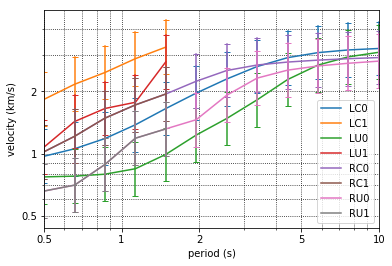

In [10]:
# show target (qc)
%run -i ../../srfpython/bin/s96 \
    --show _HerrMet_2layers/_HerrMet.target \
        -inline

# Parameterization

In [11]:
# -----------------
# set parameterization template, with two layers (in ./_HerrMet.param)
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    --param 2 3. \
        -t mZVSPRRH \
        -growing \
        -op \
    --send   
    
# the template file is no longer needed, 
# the next cells reproduce the file content in _HerrMet_*/_HerrMet.param    
os.system('rm -f ./_HerrMet.param') 

#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 2
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -3.000000        -0.001000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       PR0         1.600000         2.500000
       PR1         1.600000         2.500000
       RH0         2.200000         2.700000
       RH1         2.200000         2.700000

please customize _HerrMet.param, do not change line orders and metadata
use option --display to see the depth boundaries
cp ./_HerrMet.param _HerrMet_2layers/
cp ./_HerrMet.param _HerrMet_3layers/
cp ./_HerrMet.param _HerrMet_4layers/


0

In [12]:
# -----------------
# customize parameterization manually : 2 layers case
# -----------------
with open('_HerrMet_2layers/_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 2
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -3.000000        -0.001000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       PR0         1.79             2.12
       PR1         1.79             2.12
       RH0         2.1              2.9
       RH1         2.1              2.9""")

In [13]:
# -----------------
# customize parameterization manually : 3 layers case
# -----------------
with open('_HerrMet_3layers/_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 3
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -2.              -0.001000
       -Z3        -3.000000        -1.
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       VS2         0.100000         3.500000
       PR0         1.79             2.12
       PR1         1.79             2.12
       PR2         1.79             2.12       
       RH0         2.1              2.9
       RH1         2.1              2.9
       RH2         2.1              2.9""")
#%run -i ../../srfpython/bin/HerrMet \
#    --display _HerrMet_3layers \
#        -m96 dmtuto.mod96 \
#        -inline

In [14]:
# -----------------
# customize parameterization manually : 4 layers case
# -----------------
with open('_HerrMet_4layers/_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 4
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -1.000000        -0.001000
       -Z2        -2.000000        -0.500000
       -Z3        -3.000000        -1.000000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       VS2         0.100000         3.500000
       VS3         0.100000         3.500000
       PR0         1.79             2.12       
       PR1         1.79             2.12       
       PR2         1.79             2.12       
       PR3         1.79             2.12          
       RH0         2.1              2.9
       RH1         2.1              2.9
       RH2         2.1              2.9
       RH3         2.1              2.9""")

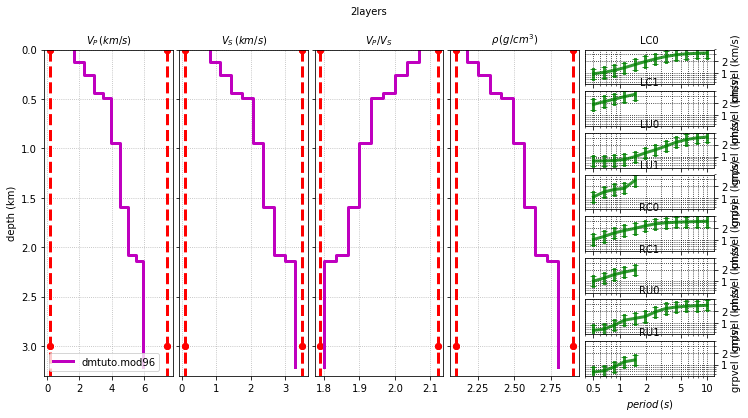

In [15]:
# check parameterizations for all 3 parameterizations
#%run -i ../../srfpython/bin/HerrMet \
#    --display \
#        -m96 dmtuto.mod96 \
#        -inline

# check parameterizations for 2 layers only
%run -i ../../srfpython/bin/HerrMet \
    --display _HerrMet_2layers \
        -m96 dmtuto.mod96 \
        -inline

In [16]:
# -----------------
# run all inversions (1 by 1) in restart mode
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -w 8 \
    -taskset "0-3" \
    -verbose 0 \
    --run \
        -nchain 16 \
        -nkeep 200 
print "DONE"

   2layers chain    2  DONE kept  200/  880 fail   71 AK 0.23 MP 0.46 AS  41.16/s LI -35.355481
   2layers chain    7  DONE kept  200/  833 fail   36 AK 0.24 MP 0.65 AS  38.88/s LI -32.844889
   2layers chain    0  DONE kept  200/  845 fail   31 AK 0.23 MP 0.58 AS  38.29/s LI -34.947838
   2layers chain    6  DONE kept  200/  899 fail   21 AK 0.22 MP 0.41 AS  38.39/s LI -31.399583
   2layers chain    3  DONE kept  200/  908 fail   35 AK 0.22 MP 0.35 AS  38.52/s LI -32.773779
   2layers chain    4  DONE kept  200/  951 fail   19 AK 0.21 MP 0.27 AS  37.94/s LI -36.542182
   2layers chain    1  DONE kept  200/  962 fail   13 AK 0.21 MP 0.24 AS  37.57/s LI -31.071973
   2layers chain    5  DONE kept  200/ 1617 fail   49 AK 0.12 MP 0.00 AS  38.80/s LI -29.955876
   2layers chain   10  DONE kept  200/  814 fail   20 AK 0.24 MP 0.64 AS  39.76/s LI -34.137506
   2layers chain    9  DONE kept  200/  856 fail   23 AK 0.23 MP 0.50 AS  38.99/s LI -32.460887
   2layers chain    8  DONE kept  200/  

top : llkmin 0.000000, limit 200, step 1 retrieved 200 models in 0.812962s 
pdf : llkmin 0.000000, limit 0, step 1 retrieved 3216 models in 1.368425s 
Stacker Worker-0002 stacked    442 jobs in 0.212723s
Stacker Worker-0001 stacked    444 jobs in 0.208677s
Stacker Worker-0003 stacked    407 jobs in 0.191702s
Stacker Worker-0007 stacked    382 jobs in 0.192652s
Stacker Worker-0008 stacked    375 jobs in 0.174166s
Stacker Worker-0006 stacked    388 jobs in 0.186333s
Stacker Worker-0004 stacked    401 jobs in 0.187747s
Stacker Worker-0005 stacked    377 jobs in 0.181188s


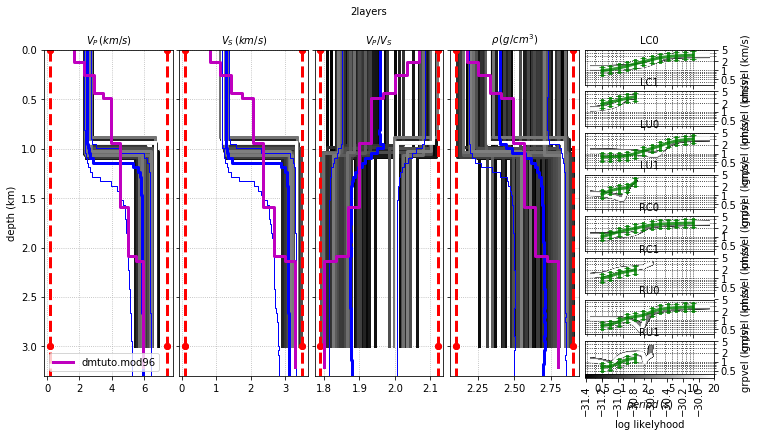

top : llkmin 0.000000, limit 200, step 1 retrieved 200 models in 0.844071s 
pdf : llkmin 0.000000, limit 0, step 1 retrieved 3215 models in 1.482505s 
Stacker Worker-0006 stacked    386 jobs in 0.243291s
Stacker Worker-0008 stacked    358 jobs in 0.242026s
Stacker Worker-0001 stacked    477 jobs in 0.306999s
Stacker Worker-0003 stacked    399 jobs in 0.269224s
Stacker Worker-0005 stacked    400 jobs in 0.258457s
Stacker Worker-0007 stacked    378 jobs in 0.249757s
Stacker Worker-0004 stacked    400 jobs in 0.268103s
Stacker Worker-0002 stacked    417 jobs in 0.265870s


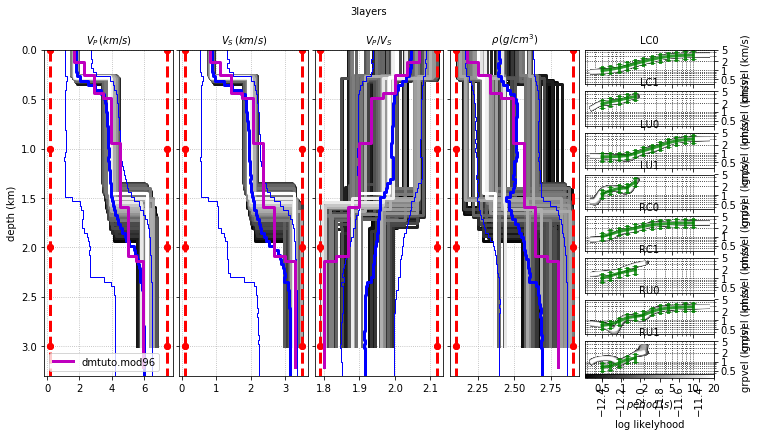

top : llkmin 0.000000, limit 200, step 1 retrieved 200 models in 0.881185s 
pdf : llkmin 0.000000, limit 0, step 1 retrieved 3211 models in 1.602885s 
Stacker Worker-0005 stacked    398 jobs in 0.355670s
Stacker Worker-0001 stacked    416 jobs in 0.357084s
Stacker Worker-0003 stacked    423 jobs in 0.360791s
Stacker Worker-0008 stacked    388 jobs in 0.329087s
Stacker Worker-0004 stacked    441 jobs in 0.376694s
Stacker Worker-0002 stacked    424 jobs in 0.351400s
Stacker Worker-0006 stacked    359 jobs in 0.324130s
Stacker Worker-0007 stacked    362 jobs in 0.343100s


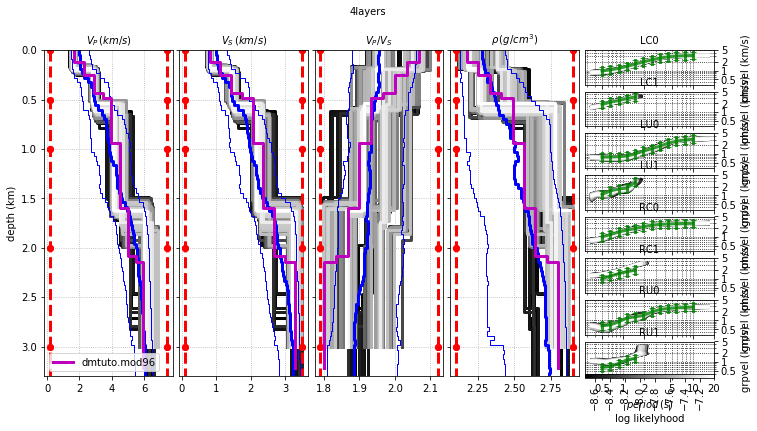

In [17]:
# -----------------
# display results
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -verbose 0 \
    --display _HerrMet_2layers _HerrMet_3layers _HerrMet_4layers \
        -top 0. 200 1 \
        -overdisp \
        -cmap gray \
        -pdf  \
        -m96 dmtuto.mod96 \
        -inline

In [21]:
#clean up
os.system('rm -rf *surf96 *mod96 _HerrMet*')

0

In [22]:
ls ./*

./tutorial1.ipynb
